In [ ]:
# pip install pandas numpy shap xgboost azure-ai-openai azure-identity tabulate
# pip install -r requirements.txt

In [1]:
import sys
import os

# sys.path.append("../risk_model")  # Adjust path as needed
# sys.path.append("./risk_model")
# sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
os.path.dirname(os.getcwd()), os.getcwd()

('/Users/leiyu/Projects/coding', '/Users/leiyu/Projects/coding/risk_model')

### 1. Load Libraries & Config

In [31]:
# Import libraries
%load_ext autoreload
%autoreload 2

import config
import shap
import pandas as pd
from tabulate import tabulate
from config import (
    # AZURE_OPENAI_ENDPOINT,
    # AZURE_OPENAI_API_KEY,
    # DEPLOYMENT_NAME,
    XGBOOST_PARAMS,
    # NUM_SAMPLES,
    # FRAUD_RATIO,
    # FEATURE_LIBRARY_CSV_PATH,
    # DUMMY_DATA_CSV,
    # TOP_N_FEATURES,
    # RISK_SCORE_DECIMALS,
    # TEST_SIZE,
    # RANDOM_STATE,
    PLOT_SHAP_SUMMARY,
    ENTITY_INDEX_FOR_EXPLANATION
)
from data.data_loader import (
    generate_feature_library_csv,
    # generate_dummy_dataset,
    generate_and_save_aml_data,
    load_dataset
)
from data.feature_library import load_feature_descriptions
from model.trainer import train_xgboost
from model.shap_utils import compute_shap_values, generate_shap_summary
from narrative.prompt_generator import build_shap_explanation_prompt

# from narrative.azure_openai_client import get_azure_openai_client, generate_narrative

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Generate Data

In [16]:
# Step 1: Generate the feature library CSV file
generate_feature_library_csv(config.DATA_PATHS["feature_library_csv"])
print(f"✅ Feature library CSV generated at: {config.DATA_PATHS['feature_library_csv']}")

# Step 2: Generate dummy AML dataset and save to CSV
dummy_df = generate_and_save_aml_data(
    num_samples=config.DATA_GENERATION["num_samples"],
    fraud_ratio=config.DATA_GENERATION["fraud_ratio"]
)
dummy_df.to_csv(config.DATA_PATHS["dummy_data_csv"], index=False)
print(f"✅ Dummy dataset saved to: {config.DATA_PATHS['dummy_data_csv']}")

# Step 3: Load the dataset into features (X) and target labels (y)
X, y = load_dataset(config.DATA_PATHS["dummy_data_csv"])

# Step 4: Display dataset shapes and target distribution
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print("Target distribution:")
print(y.value_counts())


✅ Feature library CSV saved to data/feature_library.csv
✅ Feature library CSV generated at: data/feature_library.csv
✅ Data generated and saved to data/aml_data.csv
✅ Dummy dataset saved to: data/dummy_aml_data.csv
✅ Dataset loaded from data/dummy_aml_data.csv with shape (1000, 31)
X shape: (1000, 30)
y shape: (1000,)
Target distribution:
risk_label
0    700
1    300
Name: count, dtype: int64


### 3. Train Model

In [17]:
# Train XGBoost model
model, X_test = train_xgboost(X, y, XGBOOST_PARAMS)

### 4. Explain One Example

In [18]:
# Choose an entity to explain
entity_index = ENTITY_INDEX_FOR_EXPLANATION
entity_features = X_test.iloc[[entity_index]]

# Predict risk score (probability)
risk_score = model.predict_proba(entity_features)[0, 1]
risk_score

np.float32(0.09062799)

### 5. Compute SHAP Values

In [ ]:
# Get SHAP values for the entity
top_features, shap_values = compute_shap_values(
    model,
    X,
    entity_features,
    top_n=config.SHAP_CONFIG["top_n_features"],
    plot=config.PLOT_SHAP_SUMMARY
)

In [ ]:
top_features

In [ ]:
shap_values.shape

In [ ]:
generate_shap_summary(model, X, plot_summary=True)

### 6. Load Feature Descriptions

In [ ]:
feature_descriptions = load_feature_descriptions(feature_names=X.columns)

### 7. Build Prompt

In [ ]:
prompt = build_shap_explanation_prompt(risk_score, top_features, feature_descriptions)
print("=== Prompt to LLM ===")
print(prompt)

### 8. Call Azure OpenAI

In [ ]:
client = get_azure_openai_client(AZURE_OPENAI_ENDPOINT)
narrative = generate_narrative(client, DEPLOYMENT_NAME, prompt)
print("=== LLM Narrative ===")
print(narrative)

### 9. Summarize

In [ ]:
summary_table = pd.DataFrame({
    "Entity Index": [entity_index],
    "Predicted Risk Score (%)": [round(risk_score * 100, 2)],
    "Top Features": [", ".join(top_features['Feature'])],
    "Narrative": [prompt],
    "Evaluation Score": ["N/A (manual review recommended)"]
})

print(tabulate(summary_table, headers="keys", tablefmt="fancy_grid", showindex=False))

| Step                                         | Technique                                         | LLM Prompt Strategy                                        |
| -------------------------------------------- | ------------------------------------------------- | ---------------------------------------------------------- |
| 1️⃣ Summarize top features                   | Frequency count of top N SHAP features per sample | Provide the LLM with feature counts and ask for insights   |
| 2️⃣ Identify consistent high-impact features | Mean absolute SHAP values                         | Ask LLM why these features might consistently be impactful |
| 3️⃣ Generate hypotheses                      | Combine top features with domain context          | Ask LLM to hypothesize links to business processes         |
| 4️⃣ Cluster explanations                     | Cluster mean SHAP values                          | Ask LLM to explain clusters and suggest drivers            |
| 5️⃣ Suggest actions                          | Combine features + SHAP values + business context | Prompt LLM for recommended actions and next steps          |


| Step | Function                         | Input                                        | Output          |
| ---- | -------------------------------- | -------------------------------------------- | --------------- |
| 1️⃣  | shap.Explainer                   | model, X\_test                               | shap\_values    |
| 2️⃣  | summarize\_top\_features         | shap\_values, X\_test                        | summary\_df     |
| 3️⃣  | identify\_high\_impact\_features | shap\_values, X\_test                        | mean\_abs\_shap |
| 4️⃣  | cluster\_features                | mean\_abs\_shap, n\_clusters                 | clusters\_df    |
| 5️⃣  | build\_llm\_prompt\_\*           | summary\_df / clusters\_df / mean\_abs\_shap | prompt strings  |

- Summarize Top Features
Goal: Find which features most frequently appear in the top N most impactful features across all test samples.

What it does:
For each row (sample) in X_test, it ranks features by absolute SHAP value.

Counts how often each feature shows up in the top top_n features.

Returns a DataFrame showing each feature’s name and its frequency.


- Identify High-Impact Features
Goal: Find features with the highest mean absolute SHAP value across all samples.

What it does:
Computes the mean of the absolute SHAP values for each feature across all samples.

Ranks features from most to least impactful on average.

- Cluster Features
Goal: Group features into clusters based on their mean absolute SHAP values using KMeans.

What it does:
Reshapes mean absolute SHAP values into a 2D array.

Applies KMeans to cluster features into n_clusters.

Returns a DataFrame with feature names, mean SHAP values, and cluster labels.


- Build LLM Prompts
This is where you integrate with an LLM like GPT (via Azure OpenAI or OpenAI API). You want to generate human-readable explanations or business action recommendations.

  - 5.1 Hypotheses for Top Features
Goal: Ask the LLM why each feature might influence the risk score.

  - 5.2 Cluster Explanations
Goal: Ask the LLM to interpret why features in each cluster might share similar risk signals.

  - 5.3 Action Suggestions
Goal: Ask the LLM to recommend business actions (investigations, data checks, policy improvements).



#### for single data point

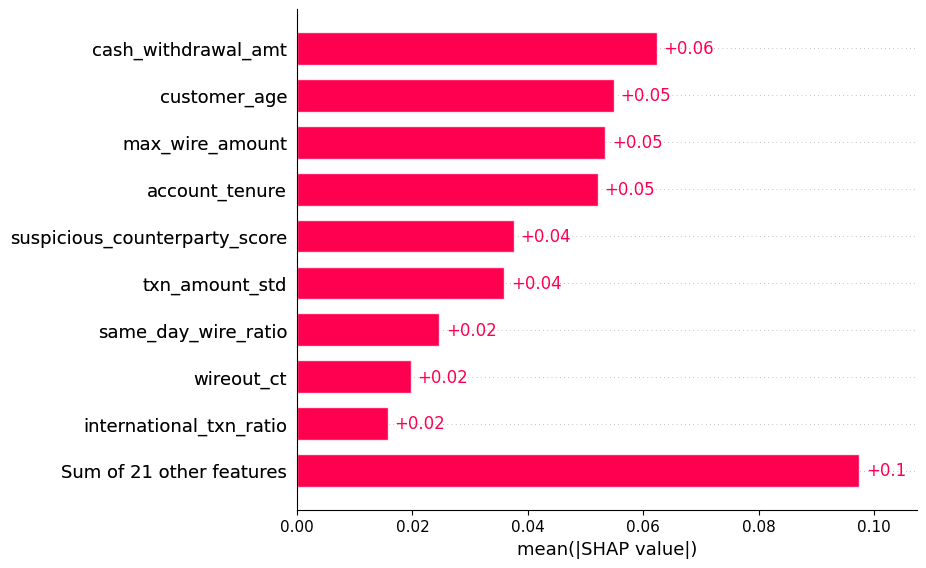

                          Feature  SHAP Value  Abs SHAP Value
14            cash_withdrawal_amt   -0.062393        0.062393
18                   customer_age    0.054946        0.054946
3                 max_wire_amount   -0.053420        0.053420
19                 account_tenure   -0.052096        0.052096
8   suspicious_counterparty_score   -0.037555        0.037555
20                 txn_amount_std   -0.035925        0.035925
7             same_day_wire_ratio   -0.024671        0.024671
1                      wireout_ct   -0.019698        0.019698
22        international_txn_ratio   -0.015757        0.015757
13               cash_deposit_amt   -0.015359        0.015359


In [39]:
single_row = X_test.iloc[[0]]  # Note the double brackets to keep it a DataFrame
top_features, shap_values = compute_shap_values(model, X, single_row)
print(top_features)

#### for multiple data points

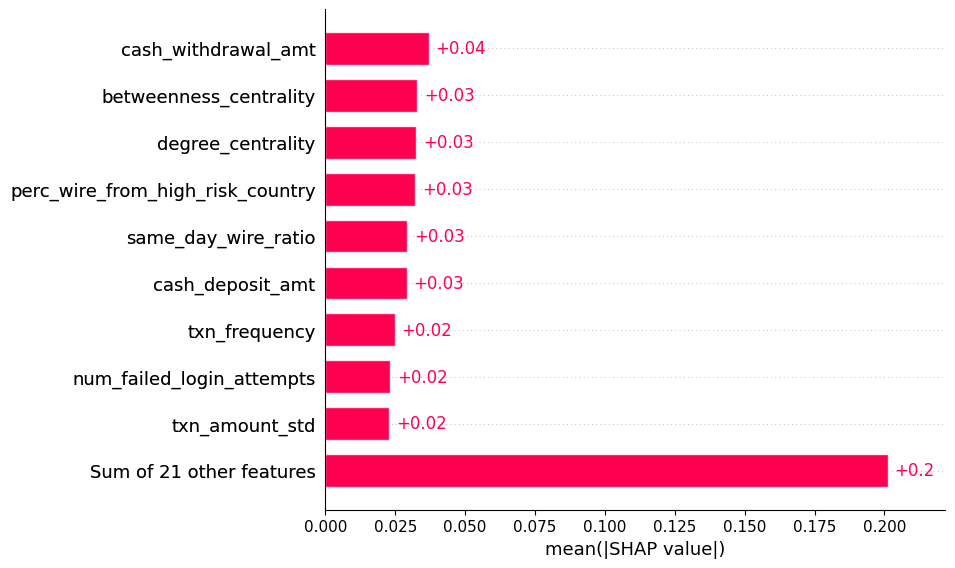

                            Feature  Mean Abs SHAP Value
0               cash_withdrawal_amt             0.037082
1            betweenness_centrality             0.032926
2                 degree_centrality             0.032506
3  perc_wire_from_high_risk_country             0.032179
4               same_day_wire_ratio             0.029349
5                  cash_deposit_amt             0.029096
6                     txn_frequency             0.024750
7         num_failed_login_attempts             0.023262
8                    txn_amount_std             0.022915
9                   avg_wire_amount             0.022706


In [40]:
top_features, shap_values = compute_shap_values(model, X, X_test)
print(top_features)

In [41]:
top_features.shape

(10, 2)

In [42]:
shap_values.shape

(200, 30)

### shap values analysis

In [43]:
import model.shap_analysis as sa

# Use these functions:
summary = sa.summarize_top_features(shap_values, X_test, top_n=10)
mean_abs = sa.identify_high_impact_features(shap_values, X_test)
clusters = sa.cluster_features(mean_abs, n_clusters=3)

In [44]:
print(summary)
print(mean_abs)
print(clusters)

                             Feature  Frequency
0                cash_withdrawal_amt        164
11  perc_wire_from_high_risk_country        148
14                 degree_centrality        142
6                same_day_wire_ratio        141
15                     txn_frequency        133
13         num_failed_login_attempts        129
10            betweenness_centrality        127
9                   cash_deposit_amt        123
2                    max_wire_amount        117
5                     txn_amount_std        113
12                   avg_wire_amount        102
4      suspicious_counterparty_score         88
3                     account_tenure         75
17    perc_wire_to_high_risk_country         69
19            clustering_coefficient         54
1                       customer_age         52
20          num_unusual_txn_patterns         40
8            international_txn_ratio         39
7                         wireout_ct         28
18      num_high_risk_counterparties    

In [45]:
hypothesis_prompt = sa.build_llm_prompt_for_hypotheses(summary["Feature"].tolist())
cluster_prompt = sa.build_llm_prompt_for_cluster_explanations(clusters)
action_prompt = sa.build_llm_prompt_for_action_suggestions(summary["Feature"].tolist(), mean_abs)

In [46]:
print(hypothesis_prompt)
print(cluster_prompt)
print(action_prompt)

You are a risk model explanation assistant. Given the following features that frequently contribute to high risk scores:

- cash_withdrawal_amt
- perc_wire_from_high_risk_country
- degree_centrality
- same_day_wire_ratio
- txn_frequency
- num_failed_login_attempts
- betweenness_centrality
- cash_deposit_amt
- max_wire_amount
- txn_amount_std
- avg_wire_amount
- suspicious_counterparty_score
- account_tenure
- perc_wire_to_high_risk_country
- clustering_coefficient
- customer_age
- num_unusual_txn_patterns
- international_txn_ratio
- wireout_ct
- num_high_risk_counterparties
- wirein_ct
- past_sar_flag
- num_large_cash_txns
- recent_address_change_flag
- num_credit_card_txns
- num_new_accounts_opened
- pep_flag
- recent_device_change_flag

For each feature:
- Explain why it might influence the risk score in an AML context.
- Suggest potential data quality issues or business processes that might cause this feature to be flagged.

You are a risk model explanation assistant. Given the foll

In [ ]:
import llm_utils

# Example prompt from shap_analysis:
prompt = "Explain why feature_A might contribute to risk in AML."

# Send to the LLM:
response = llm_utils.send_prompt_to_llm(prompt)

print("📝 LLM Response:")
print(response)

In [47]:
# from narrative.azure_openai_client import AzureClient

# azure_client = AzureClient()

# Example prompt from shap_analysis:
prompts = {
    "how's the traffic in Nework city on weekdays.",
    "What's the weather like in San Francisco today?",
    "Tell me about the latest technology trends.",
}


# for prompt in prompts:
#     response = azure_client.get_response(prompt)
#     print("LLM Response:")
#     print(f"Response for prompt "{prompt)": (response]")

for prompt in prompts:
    print("\n" + "="*50) # Separator for readability
    print(f"Prompt: {prompt}")
    # response = azure_client.get_response(prompt)
    response = f"response: {prompt}"
    print("\nLLM Response: ")
    print(response)
    print("="*50 + "\n") # End separator


Prompt: Tell me about the latest technology trends.

LLM Response: 
response: Tell me about the latest technology trends.


Prompt: What's the weather like in San Francisco today?

LLM Response: 
response: What's the weather like in San Francisco today?


Prompt: how's the traffic in Nework city on weekdays.

LLM Response: 
response: how's the traffic in Nework city on weekdays.



In [ ]:
from narrative.prompt_generator import build_feature_contribution_prompt

# Assume you already have:
# - feature_score_df
# - feature_library_df
# - risk_score_df

prompt_text = build_feature_contribution_prompt(
    feature_score_df,
    feature_library_df,
    risk_score_df
)

print("=== Prompt Text ===")
print(prompt_text)